## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
#importing Python libraries
import statsmodels.api as sm
import matplotlib.pyplot as pl
import seaborn as sn
sn.set()
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as pl
%matplotlib inline

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
#read csv data
ab= pd.read_csv('ab_data.csv')

b. Use the below cell to find the number of rows in the dataset.

In [3]:
ab.shape


(294478, 5)

c. The number of unique users in the dataset.

In [4]:
ab.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
ab['converted'].mean()


0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
treattime=ab[((ab['landing_page']=='old_page')==(ab['group']=='treatment'))]
treattime.count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

f. Do any of the rows have missing values?

In [7]:
ab.isnull().count()

user_id         294478
timestamp       294478
group           294478
landing_page    294478
converted       294478
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2=ab[((ab['group']=='treatment') == (ab['landing_page']=='new_page'))]
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df4=df2[df2['user_id'].duplicated()]['user_id']
df4.head()

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [13]:
df4=df2[df2['user_id'].duplicated()]['user_id']
df4.head()

2893    773192
Name: user_id, dtype: int64

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
#droup duplicated
df2 = df2.drop_duplicates(['user_id'])

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
#store the number of converted
df2['converted'].count()

290584

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
#make group by to calculate probability of converted
df2.groupby(['group'],as_index=False).mean()

,group,user_id,converted
0,control,788164.072594,0.120386
1,treatment,787845.719290,0.118808


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
ab[ab['group']=='control']['converted'].mean()

0.12039917935897611

d. What is the probability that an individual received the new page?

In [18]:
ab.query("( landing_page == 'new_page')").shape[0]/ab['landing_page'].count()


0.5

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Your answer goes here.**

1-there is no missing data

2-the probability of group treatment > control for converted

3-the individuals of the control group were converted by approximately 12.04% and the treatment group individuals were less than them by a very simple rate of approximately 11.96%.

4- The difference in the calculated percentages is very weak, so we need more

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

#### The null and alternative hypotheses are:

1. The Null Hypotheses: P_new - P_old <= 0:

2. The Alternative Hypotheses: P_new - P_old > 0:


**Put your answer here.**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
#where p_n is the value of pnew
p_n = df2['converted'].mean()
p_n

0.11959708724499628

#### the convert rate for  P𝑛𝑒𝑤  under the null is: 0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
##where p_o is the value of pold
p_o = df2['converted'].mean()
p_o

0.11959708724499628

#### the convert rate for  P𝑜𝑙𝑑  under the null is: 0.11959708724499628

c. What is $n_{new}$?

In [21]:
𝑛old=df2.query('group=="treatment"').fillna(0)
𝑛old1=len(df2.query('group=="treatment"'))

#Find out their number using count()
𝑛old.count(),𝑛old1

(user_id         145310
 timestamp       145310
 group           145310
 landing_page    145310
 converted       145310
 dtype: int64,
 145310)

d. What is $n_{old}$?

In [22]:
#First, define a store for each value new_page
𝑛𝑛𝑒𝑤=df2.query('group=="control"').fillna(0)
𝑛𝑛𝑒𝑤1=len(df2.query('group=="control"'))

#Find out their number using count()
𝑛𝑛𝑒𝑤.count()

user_id         145274
timestamp       145274
group           145274
landing_page    145274
converted       145274
dtype: int64

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [27]:
convert_old = df2.query(" landing_page == 'old_page' and converted == 1").shape[0]
convert_new = df2.query(" landing_page == 'new_page' and converted == 1").shape[0]
p_ol = df2['converted'].mean()
p_ol

0.11959708724499628

In [32]:
new_page_converted = np.random.binomial(1,p_ol,𝑛𝑛𝑒𝑤1).mean()
new_page_converted


0.11911973236780153

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [31]:
old_page_converted = np.random.binomial(1,p_ol,𝑛old1).mean()
old_page_converted

0.12083132613034203

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [33]:
new_page_converted-old_page_converted

-0.0017115937625405003

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [36]:
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.binomial(1,p_ol,𝑛𝑛𝑒𝑤1).mean()
    old_page_converted = np.random.binomial(1,p_ol,𝑛old1).mean()
    p_diffs.append(new_page_converted - old_page_converted)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

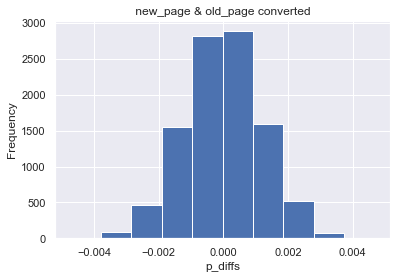

In [40]:
p_diffs = np.array(p_diffs)

# plot sampling distribution
pl.hist(p_diffs)
pl.xlabel('p_diffs')
pl.ylabel('Frequency')
pl.title(' new_page & old_page converted ');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [41]:
# define tow store 
df_cont = df2.query('group == "control"')
df_treat = df2.query('group == "treatment"')

#show the difference
obs_diff = df_treat.converted.mean() - df_cont.converted.mean()
obs_diff

-0.0015782389853555567

In [66]:
(p_diffs > obs_diff).mean()


0.9079

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Put your answer here.**

l. 90.86% is the proportion of the p_diffs that are greater than the actual difference observed in ab_data.csv. In scientific studies this value is also called p-value. this value is also called p-value. This value means that we cannot reject the null hypothesis

The z-score and the p_value mean that one doesn't reject the Null. The Null being the converted rate of the old_page is the same or greater than the converted rate of the new_page. The p_value is 0.91 and is higher than 0.05 significance level. That means we can not be confident with a 95% confidence level that the converted rate of the new_page is larger than the old_page.

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [42]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [𝑛𝑛𝑒𝑤1, 𝑛old1],alternative='larger')
z_score, p_value

(-1.2616957421858055, 0.8964708551967226)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

#### The z-score and the p_value mean that one doesn't reject the Null. The Null being the converted rate of the old_page is the same or greater than the converted rate of the new_page. The p_value is 0.91 and is higher than 0.05 significance level

**Put your answer here.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

#### This is a logistic regression, since we want to know the odds of conversion.

**Put your answer here.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [48]:
#difine column for intercept
df2['intercept'] = 1


In [43]:
#make join using landing_page
df2= df2.join(pd.get_dummies(df2['landing_page']))


In [45]:
df2['ab_page'] = pd.get_dummies(ab['group']) ['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,new_page,old_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [52]:
#log = sm.Logit(dum['converted'], dum[['user_id','ab_page']])
lo = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
res = lo.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [67]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 23 Mar 2022   Pseudo R-squ.:               8.077e-06
Time:                        18:28:17   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

#### The p-value associated with ab_page is 0.190 here, but slightly higher. This model is attempting to predict whether a user will convert depending on their page. The null hypothesis is that when ab_page = 1, converted = 0; the alternative hypothesis is that when ab_page = 1, converted is more likely to be 1.

**Put your answer here.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

#### At this point, it does not appear that the treatment or control page has much impact on whether a user converts. 

**Put your answer here.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [54]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [58]:
df3 = df2.merge(countries_df, on ='user_id', how='left')
df3.head()

,user_id,timestamp,group,landing_page,converted,new_page,old_page,ab_page,intercept,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,0,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,0,1,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,0,1,US


In [59]:
#get dummies country
df3[['CA','UK','US']] = pd.get_dummies(df3['country'])
df3 = df3.drop(df3['CA'])

In [62]:
#make logist for old and new page 
logit3 = sm.Logit(df2['converted'], df2[['old_page','new_page']])
result = logit3.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 23 Mar 2022   Pseudo R-squ.:               8.077e-06
Time:                        15:25:15   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
old_page      -1.9888      0.008   -246.669      0.000      -2.005      -1.973
new_page      -2.0038      0.008   -247.146      0.000      -2.020      -1.988
==============================================================================
"""

In [65]:
logit0 = sm.Logit(df3['converted'], df3[['intercept','ab_page','UK','US']])
result0 = logit0.fit()
result0.summary()

Optimization terminated successfully.
         Current function value: 0.366115
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290582
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            3
Date:                Wed, 23 Mar 2022   Pseudo R-squ.:               2.325e-05
Time:                        15:28:23   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1757
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.248      0.000      -2.082      -1.978
ab_page       -0.0150      0.011     -1.308      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.075      -0.005       0.106
US             0.0408      0.027      1.516      0.129      -0.012       0.093
==============================================================================
"""

In [ ]:
### Create the necessary dummy variables

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [68]:
#include interaction information of two countries out of three. (remember, when working with dummies, you drop one of them before the
df3['UK_new_page'] = df3['new_page']* df3['UK']
df3['US_new_page'] = df3['new_page']* df3['US']

In [69]:
logit4 = sm.Logit(df3['converted'], df3[['intercept','new_page','UK_new_page','US_new_page','UK','US']])
result4 = logit4.fit()
result4.summary()

Optimization terminated successfully.
         Current function value: 0.366110
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290582
Model:                          Logit   Df Residuals:                   290576
Method:                           MLE   Df Model:                            5
Date:                Wed, 23 Mar 2022   Pseudo R-squ.:               3.484e-05
Time:                        18:39:15   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1917
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -2.0040      0.036    -55.008      0.000      -2.075      -1.933
new_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK_new_page     0.0783      0.057      1.378      0.168      -0.033       0.190
US_new_page     0.0469      0.054      0.871      0.384      -0.059       0.152
UK              0.0118      0.040      0.296      0.767      -0.066       0.090
US              0.0176      0.038      0.466      0.641      -0.056       0.091
===============================================================================
"""

In [70]:
np.exp(result4.params)


intercept      0.134794
new_page       0.934776
UK_new_page    1.081428
US_new_page    1.047978
UK             1.011854
US             1.017705
dtype: float64

In [ ]:
### Fit Your Linear Model And Obtain the Results

<a id='conclusions'></a>
## Conclusions

1- Looking at the result of interactions in the logistic regression uk>us

2-p-value: 0.1984

3-old page >new page

4-LLR p-value: 0.1897

5-Based on the previous manifestations, we can say that the new page is more requested or accepted than the old one, although the difference in the ratio between them is not much

6-The p-value for the UK countries are greater than 0.05 Therefore, the null hypothesis is acceptable of page

7-90.86% is the proportion of the p_diffs that are greater than the actual difference observed in ab_data.csv. In scientific studies this value is also called p-value. this value is also called p-value. This value means that we cannot reject the null hypothesis

The z-score and the p_value mean that one doesn't reject the Null. The Null being the converted rate of the old_page is the same or greater than the converted rate of the new_page. The p_value is 0.91 and is higher than 0.05 significance level. That means we can not be confident with a 95% confidence level that the converted rate of the new_page is larger than the old_page.


In conclusion, there is not enough evidence that the new_page increases the conversion rate as compared to the old_page. This is based on the probability figures, A/B testand regression. There is no strong evidence that the countries (US, CA and UK) influence the conversion rate.

Since the sample size is large continuing the testing of the new_page is likely not necessary. It is best to focus on the development of another new landing page.


